In [30]:
from keras.engine import  Model
from tensorflow.keras.models import load_model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K

EPOCHS = 20
BATCH_SIZE = 8
hidden_dim = 256
MODEL_PATH = './saved_model/multi_task.h5'

ckp = ModelCheckpoint(
    MODEL_PATH,
    monitor= 'val_loss',
    mode = 'min',
    verbose=1,
    save_best_only=True,
    save_weights_only = False)

es = EarlyStopping(
    monitor= 'val_loss',
    patience=3,
    verbose=0,
    mode='min')

callbacks = [ckp, es]

def multi_task_model(hidden_dim):
    vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3))
    for layer in vgg_model.layers:
        layer.trainable = False

    last_layer = vgg_model.get_layer('pool5').output
    flatten = Flatten(name='flatten')(last_layer)

    x = Dense(hidden_dim, activation='relu', name='bmi_fc1')(flatten)
    x = Dense(hidden_dim, activation='relu', name='bmi_fc2')(x)
    out_bmi = Dense(1, activation='linear', name='bmi')(x)

    x = Dense(hidden_dim, activation='relu', name='age_fc1')(flatten)
    x = Dense(hidden_dim, activation='relu', name='age_fc2')(x)
    out_age = Dense(1, activation = 'linear', name = 'age')(x)

    x = Dense(hidden_dim, activation='relu', name='sex_fc1')(flatten)
    x = Dense(hidden_dim, activation='relu', name='sex_fc2')(x)
    out_sex = Dense(1, activation = 'sigmoid', name = 'sex')(x)

    custom_vgg_model = Model(vgg_model.input, [out_bmi, out_age, out_sex])
    custom_vgg_model.compile('adam', 
                         {'bmi':'mean_squared_error','age':'mean_squared_error','sex':'binary_crossentropy'},
                         {'bmi': 'mae','age':'mae','sex': 'accuracy'})
    
    return custom_vgg_model

In [34]:
try:
    model = load_model(MODEL_PATH)
    print('load existing model')
except:
    print('create new model')
    model = multi_task_model(hidden_dim = hidden_dim)
    
model.summary()

create new model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 224, 224, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 224, 224, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 112, 112, 64) 0           conv1_2[0][0]                    
____________________________________________________________________________________________

In [35]:
def preprocess(train):
    train = train.loc[train['index'].isin(all_images),:]
    train.sex = train.sex.map(lambda i: 1 if i == 'Male' else 0).values
    train = train.rename(columns = {'index':'img'})
    train = train.reset_index(drop = True).reset_index()
    return train

In [36]:
all_images = os.listdir('./face/')
train = pd.read_csv('./train.csv', usecols = ['index','bmi','age','sex'])
train = preprocess(train)
train.head()

C:\Users\n174724\.conda\envs\face2bmi\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,index,age,sex,bmi,img
0,0,54,1,39.047808,248038.jpg
1,1,26,1,29.285856,250464.jpg
2,2,24,1,42.820836,263711.jpg
3,3,21,1,23.025951,270020.jpg
4,4,18,1,19.004109,279426.jpg


In [37]:
valid = pd.read_csv('./valid.csv', usecols = ['index','bmi','age','sex'])
valid = preprocess(valid)
valid.head()

,index,age,sex,bmi,img
0,0,29,1,29.527027,277774.jpg
1,1,39,1,19.523904,285657.jpg
2,2,20,1,20.221186,287504.jpg
3,3,23,0,35.424540,288892.jpg
4,4,19,1,19.134911,289141.jpg


In [38]:
train_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 30,
    shear_range = 10,
    zoom_range = [1,1.25],
    horizontal_flip = True, 
    vertical_flip = True) #included in our dependencies

valid_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input) #included in our dependencies

In [39]:
def multilabel_flow_from_dataframe(datagen, df):
    for x, y in datagen:
        indices = y.astype(np.int).tolist()
        y_multi = [df.loc[df['index'].isin(indices),'bmi'].values, 
                   df.loc[df['index'].isin(indices),'age'].values,
                   df.loc[df['index'].isin(indices),'sex'].values]
        yield x, y_multi

In [40]:
train_generator=train_datagen.flow_from_dataframe(train, directory = './face', x_col = 'img', y_col = 'index', 
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='other',
                                                 shuffle=True)

valid_generator=valid_datagen.flow_from_dataframe(valid, directory = './face', x_col = 'img', y_col = 'index',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='other')
train_generator = multilabel_flow_from_dataframe(train_generator, train)
valid_generator = multilabel_flow_from_dataframe(valid_generator, valid)

Found 693 validated image filenames.
Found 183 validated image filenames.


In [41]:
model.fit_generator(train_generator,
                                steps_per_epoch=100,
                                epochs=EPOCHS,
                                verbose=1,
                                validation_data=valid_generator,
                                validation_steps=20,
                                callbacks=callbacks,
                                max_queue_size=10,
                                workers=1,
                                use_multiprocessing=False,
                                shuffle=True)

Epoch 1/20
100/100 [==============================] - 155s 2s/step - loss: 501.9290 - bmi_loss: 208.5433 - age_loss: 290.5029 - sex_loss: 2.8828 - bmi_mean_absolute_error: 8.2846 - age_mean_absolute_error: 12.9839 - sex_acc: 0.8162 - val_loss: 244.9190 - val_bmi_loss: 58.0777 - val_age_loss: 184.4500 - val_sex_loss: 2.3914 - val_bmi_mean_absolute_error: 5.7687 - val_age_mean_absolute_error: 11.5423 - val_sex_acc: 0.8500

Epoch 00001: val_loss improved from inf to 244.91905, saving model to ./saved_model/multi_task.h5
Epoch 2/20
100/100 [==============================] - 153s 2s/step - loss: 239.0413 - bmi_loss: 46.5129 - age_loss: 189.8978 - sex_loss: 2.6306 - bmi_mean_absolute_error: 5.2717 - age_mean_absolute_error: 10.9241 - sex_acc: 0.8350 - val_loss: 185.6706 - val_bmi_loss: 32.8721 - val_age_loss: 149.1889 - val_sex_loss: 3.6096 - val_bmi_mean_absolute_error: 4.3961 - val_age_mean_absolute_error: 9.4705 - val_sex_acc: 0.7736

Epoch 00002: val_loss improved from 244.91905 to 185.6

AttributeError: 'Model' object has no attribute '_ckpt_saved_epoch'

In [23]:
test = valid.sample(10)
test.head()

# make predictions
test_generator=valid_datagen.flow_from_dataframe(test, directory = './face', x_col = 'img', y_col = 'index',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='other')
steps = ((test.shape[0] + 0.1) // BATCH_SIZE) + 1

preds = custom_vgg_model.predict_generator(test_generator, steps = steps)
preds_bmi, preds_age, preds_sex = preds

test['preds_bmi'] = preds_bmi[:,0]
test['preds_age'] = preds_age[:,0].astype(int)
test['preds_sex'] = preds_sex[:,0].astype(int)

test

Found 10 validated image filenames.


,index,age,sex,bmi,img,preds_bmi,preds_age,preds_sex
170,170,32,1,29.834105,298079.jpg,24.487528,32,1
20,20,61,1,24.820204,292606.jpg,22.733585,17,1
32,32,31,1,28.188906,293419.jpg,26.571520,21,1
85,85,33,1,25.102162,296019.jpg,27.507257,31,1
55,55,33,1,21.284602,294888.jpg,26.001080,29,1
29,29,60,1,25.176309,293177.jpg,28.852198,32,1
173,173,54,1,22.313033,298150.jpg,27.334393,27,1
148,148,31,1,30.406574,297780.jpg,23.085443,33,1
180,180,36,1,24.389796,298225.jpg,23.630051,27,1
96,96,23,0,36.840903,296393.jpg,25.699400,32,1


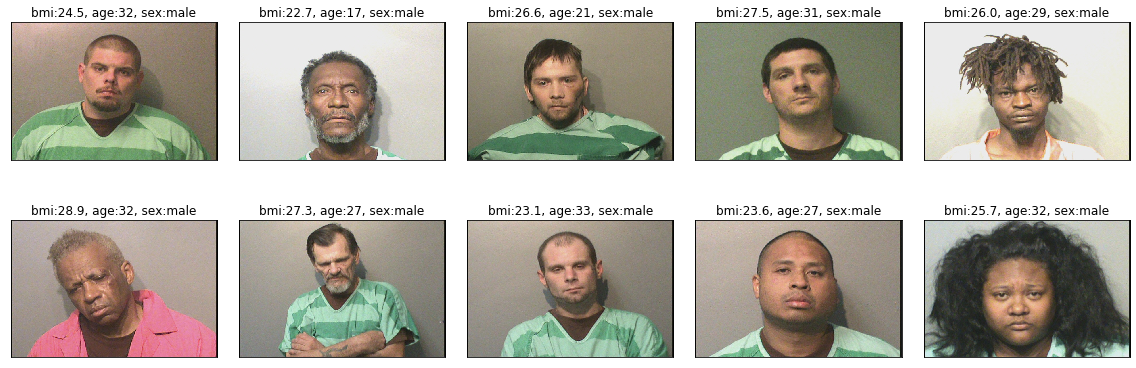

In [24]:
# visulize predictions
fig, axs = plt.subplots(2,5)
fig.set_size_inches(16,6)
for i in range(test.shape[0]):
    res = plt.imread('./face/%s'%(test.img.iloc[i]))
    row, col = i // 5, i % 5
    ax = axs[row, col]
    ax.imshow(res)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('bmi:%3.1f, age:%d, sex:%s'%(preds_bmi[i], int(preds_age[i]), 'male' if preds_sex[i] == 1 else 'female'))
plt.tight_layout()
plt.show()

In [25]:
test = pd.read_csv('./test.csv')
# make predictions
test_generator=valid_datagen.flow_from_dataframe(test, directory = './test', x_col = 'img', y_col = 'index',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='other')
#test_generator = multilabel_flow_from_dataframe(test_generator, test)
steps = int(((test.shape[0] + 0.1) // BATCH_SIZE) + 1)

preds = custom_vgg_model.predict_generator(test_generator, steps = steps)
preds_bmi, preds_age, preds_sex = preds

test['preds_bmi'] = preds_bmi[:,0]
test['preds_age'] = preds_age[:,0].astype(int)
test['preds_sex'] = preds_sex[:,0].astype(int)

test

Found 9 validated image filenames.


,index,img,preds_bmi,preds_age,preds_sex
0,0,albert-einstein.jpg,37.330521,37,1
1,1,barack-obama.jpg,31.134041,32,1
2,2,bill-gates.jpg,33.436489,43,1
3,3,emma_watson.jpg,27.764584,34,1
4,4,hilary_clinton.jpg,28.164139,37,1
5,5,kent_zheng.jpg,32.255142,40,1
6,6,Kim Jong-un.jpg,33.301678,33,1
7,7,leonardo.jpeg,36.763412,47,1
8,8,trump.jpg,28.469667,31,1


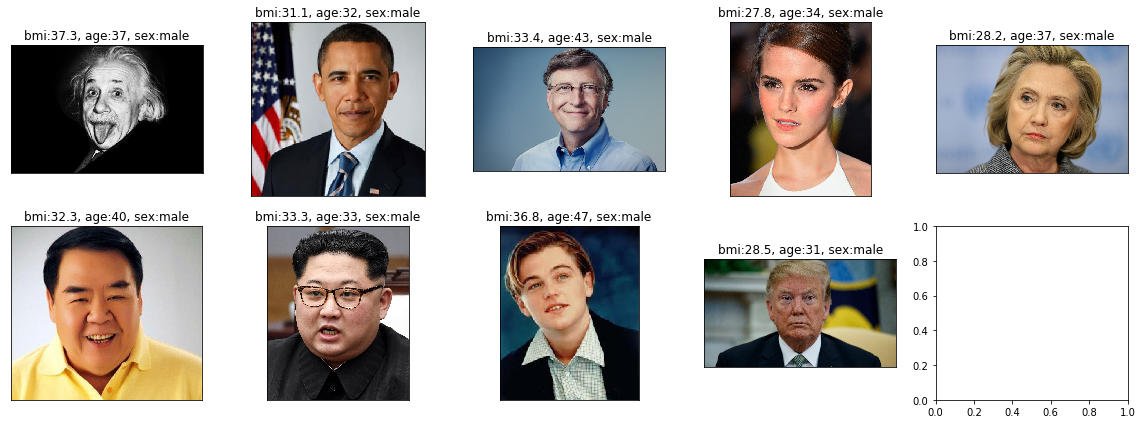

In [26]:
# visulize predictions
fig, axs = plt.subplots(2,5)
fig.set_size_inches(16,6)
for i in range(test.shape[0]):
    res = plt.imread('./test/%s'%(test.img.iloc[i]))
    row, col = i // 5, i % 5
    ax = axs[row, col]
    ax.imshow(res)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('bmi:%3.1f, age:%d, sex:%s'%(preds_bmi[i], int(preds_age[i]), 'male' if preds_sex[i] == 1 else 'female'))
plt.tight_layout()
plt.show()